In [15]:
#    STEP 1:
# Load the experiment data by import load_svmlight_file function in sklearn library
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt 
import numpy as np

# this function for  read data
def getData(fileName):

	data = load_svmlight_file(fileName)
	return data[0], data[1]

# this function for Add a column after the matrix data
def addColumnData(dataMatrix, dataType):
    
    row, col = dataMatrix.shape
    onesArray = np.ones(row)
    dataArray = dataMatrix.toarray()
    if dataType == "train":
        dataTrans = np.column_stack((dataArray, onesArray))
    elif dataType == 'test':
        zeroArray = np.zeros(row)
        tempTrans = np.column_stack((dataArray, zeroArray))
        dataTrans = np.column_stack((tempTrans, onesArray))
    return dataTrans

# this function for Initialize the weights
def initialWeights(data, initialModel = None): 
# data is data matrix, each row is a sample, each column is a dimension
	row, col = data.shape
	if initialModel == None:
		weights = np.zeros(col)
	elif initialModel == "random":
		weights = np.random.rand(col)
	elif initialModel == "normality":
		weights = np.random.standard_normal(col)
	return weights # Returns the weight value

def minibatchData(dataMatrix, dataLabel, sampleNum):
    row, col = dataMatrix.shape
    randNum = np.random.randint(0, row-51)
    miniData = dataMatrix[randNum:(randNum+sampleNum), :]
    miniDataLabel = dataLabel[randNum:(randNum+sampleNum)]
    return miniData, miniDataLabel

# this fun. Stochastic gradient declines
def stochasticGradientDescent(dataMatrix, dataLabel, weightsParam, lamb):
  
    miniDataMatrix, miniDataLabel = minibatchData(dataMatrix, dataLabel, 50)
    row, col = miniDataMatrix.shape
    YWX = getYWX(miniDataMatrix, miniDataLabel, weightsParam)
    eYWX = np.exp(YWX)
    onesArray = np.ones(row)
    addEYWX = onesArray + eYWX
    transData = np.transpose(miniDataMatrix)
    temp = transData / addEYWX * miniDataLabel * (-1)
    G = np.mean(temp, axis=1) + lamb * weightsParam
    return G

#this function to NAG update weight 
def NAGUpdateWeights(weightsParam, v, D, alpha1, alpha2):      
    newV = alpha1 * v + alpha2 * D
    newWeights = weightsParam - newV
    return newWeights, newV

# this fun. perform : RMSprop update weight
def RMSPROPUpdateWeights(weightsParam, D, decayRate, cacheParam, learningRate):
    eps = 1.0e-8
    newcache = decayRate * cacheParam + (1 - decayRate) * D * D
    newWeights = weightsParam - learningRate * D / (np.sqrt(newcache+ eps))
    return newWeights, newcache

#  this fun. perform : adaDelta update weight
def adaDeltaUpdateWeights(weightsParam, DParam, GTParam, deltaParam, GRateParam):
    eps = 1.0e-6
    newGT = GRateParam * GTParam + (1 - GRateParam) * DParam * DParam
    tempValue = np.sqrt(deltaParam + eps) / np.sqrt(newGT + eps) * DParam * (-1)
    newWeights = weightsParam + tempValue
    newdelta = GRateParam * deltaParam + (1-GRateParam) * tempValue * tempValue
    return newWeights, newGT, newdelta

# this fun. perform  Adam updates weight
def adamUpdateWeights(weightsParam, DParam, mParam, vParam, belta1, belta2, alpha, t):
    eps = 1.0e-6
    newM = belta1 * mParam + (1-belta1) * DParam
    newV = belta2 * vParam + (1-belta2) * DParam * DParam
    tempM = newM / (1-np.power(belta1,t))
    tempV = newV / (1-np.power(belta2,t))
    newWeights = weightsParam - alpha * tempM / (np.sqrt(tempV) + eps)
    return newWeights, newM, newV


def addV(weightsParam, v, alpha):
   
    newWeights = weightsParam - alpha * v
    return newWeights   

def  plotPicture(LossList1, LossList2, LossList3, LossList4):
   
    plt.title('loss value vary ')
    plt.plot(LossList1, color="blue", linewidth=2.5, linestyle = "-", label="NAGLoss")
    plt.plot(LossList2, color="red", linewidth=2.5, linestyle="-", label="RMSPropLoss")
    plt.plot(LossList3, color="green", linewidth=2.5, linestyle="-", label="AdadeltaLoss")
    plt.plot(LossList4, color="black", linewidth=2.5, linestyle="-", label="AdamLoss")
    plt.legend(loc="upper right")
    plt.xlabel("Fig.2")
    plt.ylabel("loss")
    plt.show()

def svmModelCalculate(dataLabel, predictLabel):
    
   # this fun. perform  Calculate（1-y*y^）
   # dateLabel is The real label of the sample data
   # predictLabel is predictive label for the sample data
    
    value = dataLabel * predictLabel
    length = len(dataLabel)
    oneArrary = np.ones(length)
    value2 = oneArrary - value
    return value2

 # this function is Calculate Loss value
def svmModelLossFunction(weights, dataLabel, dataMatrix, C):
    
    predictValue = dataMatrix * weights
    predictLabel = predictValue.sum(axis = 1)
    differenceValue = svmModelCalculate(dataLabel, predictLabel)
    row, col = dataMatrix.shape
    tempArray = np.zeros(row)
    for i in range(row):
        if differenceValue[i] >= 0:
            tempArray[i] = differenceValue[i]
    tempValue = np.mean(tempArray) * C
    tempW = np.sum(weights * weights)/ 2
    loss = tempW + tempValue
    return loss

 # this function get the classification result
def getResult(weights, dataLabel, dataMatrix, threshold):
      
    predictValue = dataMatrix * weights
    predictLabel = predictValue.sum(axis = 1)
    row, col = dataMatrix.shape
    resultArray = np.zeros(row)
    for i in range(row):
        if predictLabel[i] > threshold:
            resultArray[i] = 1
        else:
            resultArray[i] = -1
    return resultArray

# this function Calculate the gradient under svm model
def svmModelMiniGradientDescent(weights, dataLabel, dataMatrix, C):
       
    miniDataMatrix, miniDataLabel = minibatchData(dataMatrix, dataLabel, 50)
    predictValue = miniDataMatrix * weights
    predictLabel = predictValue.sum(axis = 1)
    differenceValue = svmModelCalculate(miniDataLabel, predictLabel)
    row, col = miniDataMatrix.shape
    tempValue = np.zeros(row)
    for i in range(row):
        if differenceValue[i] >= 0:
            tempValue[i] = miniDataLabel[i]
    tempG = np.transpose(miniDataMatrix) * tempValue * (-1)
    G = np.mean(tempG, axis = 1) * C + weights
    return G

def svmModelClassification():
    fileName = 'datasets/a9a'
    dataMatrix, dataLabel = getData(fileName)
    dataArray = addColumnData(dataMatrix, "train")
    testFileName = 'datasets/a9a.t'
    testDataMatrix, testDataLabel = getData(testFileName)
    testDataArray = addColumnData(testDataMatrix, 'test')
    weights = initialWeights(testDataArray, initialModel = "random")
    weightsRms = initialWeights(testDataArray, initialModel = "random")
    weightsAda = initialWeights(testDataArray, initialModel = 'random')
    weightsAdam = initialWeights(testDataArray, initialModel = "random")
    vNAG = initialWeights(testDataArray, initialModel = None)
    cache = initialWeights(testDataArray, initialModel = None)
    GT = initialWeights(testDataArray, initialModel = None)
    delta = initialWeights(testDataArray, initialModel = None)
    adamM = initialWeights(testDataArray, initialModel = None)
    adamV = initialWeights(testDataArray, initialModel = None)
    NAGLossList = []
    RMSLossList = []
    ADALossList = []
    AdamLossList = []
    iterNum = 200
    alpha1 = 0.9   
    alpha2 = 0.01  #rate of learning 
    alpha3 = 0.5
    decayRate = 0.9
    GRate = 0.95
    belta1 = 0.9
    belta2 = 0.999
    adamAlpha = 0.01
    for i in range(iterNum):
        #NAG
        testLoss = svmModelLossFunction(weights, testDataLabel, testDataArray, C=1)
        NAGLossList.append(testLoss)
        weightNAG = addV(weights, vNAG, alpha1)
        DNAG = svmModelMiniGradientDescent(weightNAG, dataLabel, dataArray, C=1)
        weights, vNAG =NAGUpdateWeights(weightNAG, vNAG, DNAG, alpha1, alpha2)
        #RMWSprop
        testLoss1 = svmModelLossFunction(weightsRms, testDataLabel, testDataArray, C=1)
        RMSLossList.append(testLoss1)
        DRMS = svmModelMiniGradientDescent(weightsRms, testDataLabel, testDataArray, C=1)
        weightsRms, cache = RMSPROPUpdateWeights(weightsRms, DRMS, decayRate, cache, alpha2)
        #adaDelta
        testLoss2 = svmModelLossFunction(weightsAda, testDataLabel, testDataArray, C=1)
        ADALossList.append(testLoss2)
        DADA = svmModelMiniGradientDescent(weightsAda, testDataLabel, testDataArray, C=1)
        weightsAda, GT, delta = adaDeltaUpdateWeights(weightsAda, DADA, GT, delta, GRate)
        #Adam
        testLoss3 = svmModelLossFunction(weightsAdam, testDataLabel, testDataArray, C=1)
        AdamLossList.append(testLoss3)
        DAdam = svmModelMiniGradientDescent(weightsAdam, testDataLabel, testDataArray, C=1)
        weightsAdam, adamM, adamV = adamUpdateWeights(weightsAdam, DAdam, adamM, adamV, belta1, belta2, adamAlpha, i+1)
    plotPicture(NAGLossList, RMSLossList, ADALossList, AdamLossList)

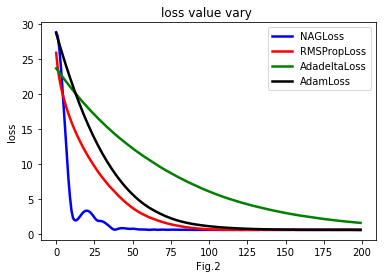

In [16]:
svmModelClassification()